In [2]:
import pandas as pd
import numpy as np
import os
import CRPS.CRPS as pscore
import copy
from joblib import dump, load
from time import sleep
from tqdm import tqdm
import warnings


def check_Actuals(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        return False
    else:
        return True

# check if the last month of a country in the feature dataset is 3 months before the first month that has to be predicted
def check_last_featureMonth(country_id, dataindex):
    # Check if the country_id exists in actual dataset
    if country_id not in country_actual_group_list[dataindex].groups.keys():
        raise ValueError('country does not have actuals')


    # last month of the feature dataset
    last_feature_month = country_feature_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[-1]

    # first month of the actual dataset
    first_actual_month = country_actual_group_list[dataindex].get_group(country_id).index.get_level_values('month_id').unique().tolist()[0]

    # if the last month of the feature dataset in the country does not match the first of the actuals return false
    if (first_actual_month - 3) != last_feature_month:
        return False
    else:
        return True


# create the feature- and actuals-data list
# set the feature and actuals year lists
feature_years = ['2017','2018','2019','2020']
actual_years = ['2018','2019','2020','2021']

actuals_df_list = []
features_df_list = []

# path to the current directory
current_dir = os.getcwd()

for i in range(len(feature_years)):
    # relative paths to the parquet files
    relative_path_features = os.path.join('..', 'data', 'cm_features_to_oct' + feature_years[i] + '.parquet')
    relative_path_actuals = os.path.join('..', 'data', 'cm_actuals_' + actual_years[i] + '.parquet')

    path_features = os.path.join(current_dir, relative_path_features)
    path_actuals = os.path.join(current_dir, relative_path_actuals)

    # append datasets to the lists
    actuals_df_list.append({'year':actual_years[i], 'data':pd.read_parquet(path_actuals, engine='pyarrow')})
    features_df_list.append({'year':feature_years[i], 'data':pd.read_parquet(path_features, engine='pyarrow')})

# concat the feature datasets, so that every data contains the observations starting with january 1990
for i in range(1,len(features_df_list)):
    features_df_list[i]['data'] = pd.concat([features_df_list[i-1]['data'], features_df_list[i]['data']])


from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor


data = features_df_list[-1]['data']
if 'gleditsch_ward' in data.columns:
    data = data.drop(columns='gleditsch_ward') # column not necessary

## Features without missing values
columns_without_missing_values = data.columns[data.notna().all()]

for i in range(len(features_df_list)):
    data_set = features_df_list[i]['data']
    features_df_list[i]['data'] = data_set[columns_without_missing_values]

# last dataset contains all other datasets (because of concat) 
all_features = features_df_list[-1]['data'].columns


country_list = sorted(features_df_list[3]['data'].index.get_level_values('country_id').unique().tolist())

# country group list of all four datasets
country_feature_group_list = []
country_actual_group_list = []
# fill list 
for i in range(len(features_df_list)):
    country_feature_group_list.append(features_df_list[i]['data'].groupby('country_id'))
    country_actual_group_list.append(actuals_df_list[i]['data'].groupby('country_id'))

relative_path_countrylist = os.path.join('..', 'data', 'country_list.csv')
path_countrylist = os.path.join(current_dir, relative_path_countrylist)

# CSV-Datei einlesen und als Pandas-Datensatz speichern
countryList_prediction = pd.read_csv(path_countrylist)
country_list_views = countryList_prediction.loc[:,'country_id'].values.tolist() 

month_list = []
countries_to_remove = []
for country_id in country_list:

    if country_id in country_list_views:
        feature_data_views = country_feature_group_list[0].get_group(country_id)

        # numbers of months from the feature dataset
        month_list_feature_data_original = feature_data_views.index.get_level_values('month_id').tolist()
        number_months_feature_data = len(month_list_feature_data_original) 

        # check if actuals exist for the country
        if check_Actuals(country_id, 0):
            # check if the last feature month is 3 months before the first actuals month
            if not check_last_featureMonth(country_id, 0): 
                month_list.append([str(country_id) +' last month missing'])
            else:
                month_list.append([number_months_feature_data, country_id])
        else:
            month_list.append(str(country_id) + ' no actuals')
    else:
        countries_to_remove.append(country_id)

country_list = list(set(country_list) - set(countries_to_remove))
month_list.sort()


## Result plots

In [3]:
zero_fatalities_country_list = []
countries_with_low_conflict_list = []
countries_with_middle_conflict_list = []
countries_with_high_conflict_list = []

for country_id in country_list:
    feature_data = country_feature_group_list[3].get_group(country_id)

    # Berechnen des Prozentsatzes der Werte größer als 0 in der Spalte 'ged_sb'
    mean_fatalities = np.mean(feature_data['ged_sb'].tail(4*12))

    if mean_fatalities == 0:
        zero_fatalities_country_list.append(country_id)
    elif mean_fatalities > 0 and mean_fatalities <= 5:
        countries_with_low_conflict_list.append(country_id)
    elif mean_fatalities > 5 and mean_fatalities <= 100:
        countries_with_middle_conflict_list.append(country_id)
    else:
        countries_with_high_conflict_list.append(country_id)

countries_with_high_conflict_list

[60, 79, 120, 124, 133, 167, 220]

In [29]:
import pandas as pd
from joblib import load
import numpy as np

prediction_data_list = []

for year in actual_years:
    # Pfad zur Parquet-Datei
    parquet_file_path = r'C:\Users\Tobias\Documents\BAconflictPrediction\ConflictPrediction\benchmark views\bm_cm_last_historical_poisson_expanded_' + year + '.parquet'
    # Parquet-Datei in ein DataFrame einlesen
    benchmark_data = pd.read_parquet(parquet_file_path)

    parquet_file_path = r'C:\Users\Tobias\Documents\BAconflictPrediction\ConflictPrediction\plots_model_comp\bodentien_rueter_cm_nbinom_test_window_' + year + '.parquet'
    # Parquet-Datei in ein DataFrame einlesen
    baseline_nbinom_data = pd.read_parquet(parquet_file_path)

    parquet_file_path = r'C:\Users\Tobias\Documents\BAconflictPrediction\ConflictPrediction\plots_model_comp\cm_hurdle_test_window_' + year + '.parquet'
    # Parquet-Datei in ein DataFrame einlesen
    baseline_hurdle_data = pd.read_parquet(parquet_file_path)

    parquet_file_path = r'C:\Users\Tobias\Documents\BAconflictPrediction\ConflictPrediction\plots_model_comp\cm_NeuralNet_test_window_' + year + '.parquet'
    # Parquet-Datei in ein DataFrame einlesen
    nn_data = pd.read_parquet(parquet_file_path)

    parquet_file_path = r'C:\Users\Tobias\Documents\BAconflictPrediction\ConflictPrediction\plots_model_comp\cm_NeuralNetNegBin_test_window_' + year + '.parquet'
    # Parquet-Datei in ein DataFrame einlesen
    nn_negbin_data = pd.read_parquet(parquet_file_path)

    prediction_data_list.append({'benchmark':benchmark_data,
                                 'NB':baseline_nbinom_data,
                                 'Hurdle':baseline_hurdle_data,
                                 'NN':nn_data,
                                 'NNNegBin':nn_negbin_data
                                 })
    
    a = benchmark_data.index.get_level_values('month_id').unique()
    b = baseline_nbinom_data.index.get_level_values('month_id').unique()
    c = baseline_hurdle_data.index.get_level_values('month_id').unique()
    d = nn_data.index.get_level_values('month_id').unique()
    e = nn_negbin_data.index.get_level_values('month_id').unique()

    if not all(a == b):
        print('NB Months falsch year' + str(year))
    elif not all(a == c):
        print('Hurdle months flasch year' + str(year))
    elif not all(a == d):
        print('NN months flasch year' + str(year)) 
    elif not all(a == e):
        print('NN Negbin months flasch year' + str(year))

# Country specific plots
## CDF of three countries

C:\Users\Tobias\AppData\Local\Temp\ipykernel_20432\379743369.py:18: PerformanceWarning: indexing past lexsort depth may impact performance.
  empirical_distribution_NN = nn_data.loc[(prediction_month,country_to_plot),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_20432\379743369.py:50: PerformanceWarning: indexing past lexsort depth may impact performance.
  empirical_distribution_NBbaseline = baseline_nbinom_data.loc[(prediction_month,country_to_plot),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_20432\379743369.py:82: PerformanceWarning: indexing past lexsort depth may impact performance.
  empirical_distribution_HURDLEbaseline = baseline_hurdle_data.loc[(prediction_month,country_to_plot),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_20432\379743369.py:114: PerformanceWarning: indexing past lexsort depth may impact performance.
  empirical_distribution_NNNegBin = nn_negbin_data.loc[(prediction_month,country_to_plot),:].values.fl

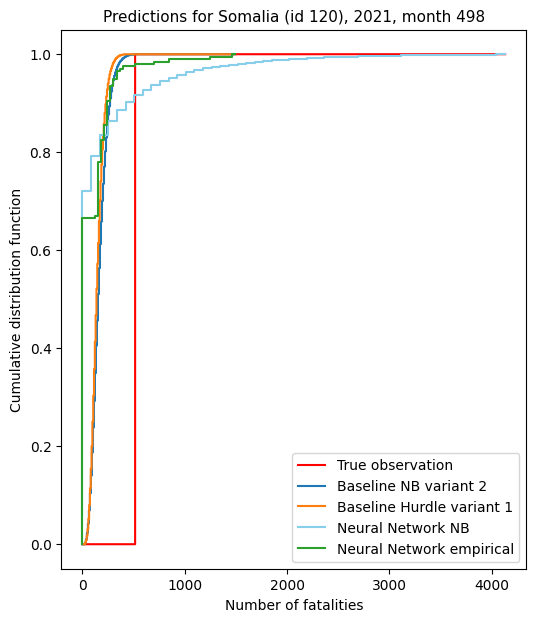

In [30]:
#------------------------------------
prediction_year = '2021' # 2019, 2020, 2021
country_to_plot = 120 # 73 50 120
s = 8 #8
#------------------------------------
dataset_index = actual_years.index(prediction_year)
actual_data = actuals_df_list[dataset_index]['data']
actual_group = actual_data.groupby('country_id')
prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
y_true = actual_group.get_group(country_to_plot).iloc[s-3,0]

import numpy as np
import statsmodels.api as sm # recommended import according to the docs
import matplotlib.pyplot as plt

## neural net empirical-------------------------------------------------------------------------------
nn_data = prediction_data_list[dataset_index]['NN']
empirical_distribution_NN = nn_data.loc[(prediction_month,country_to_plot),:].values.flatten()
empirical_distribution_NN = np.sort(empirical_distribution_NN)

sample = empirical_distribution_NN
ecdf = sm.distributions.ECDF(sample)

x_nn = np.linspace(min(sample), max(sample))
y_nn = ecdf(x_nn)

below_min = np.array(range(0, min(sample)))
x_nn = np.concatenate((below_min, x_nn))
num_zeros = len(below_min)
y_nn = np.concatenate((np.array([0]*num_zeros), y_nn))

## make sure that (0,0) is included
x_nn = np.concatenate((np.array([0]), x_nn))
y_nn = np.concatenate((np.array([0]), y_nn))

if y_true < max(sample):
    max_value = max(sample) + 5
else:
    max_value = int(y_true) + 5

max_for_all = max_value # nn emp has the heaviest tail -> max value for all others

above_max = np.array(range(max(sample)+1, max_value))
x_nn = np.concatenate((x_nn, above_max))
num_ones = len(above_max)
y_nn = np.concatenate((y_nn , np.array([1]*num_ones)))

## baseline negative binomial-----------------------------------------------------------
baseline_nbinom_data = prediction_data_list[dataset_index]['NB']
empirical_distribution_NBbaseline = baseline_nbinom_data.loc[(prediction_month,country_to_plot),:].values.flatten()
empirical_distribution_NBbaseline = np.sort(empirical_distribution_NBbaseline)

sample = empirical_distribution_NBbaseline
ecdf = sm.distributions.ECDF(sample)

x_nb = np.linspace(min(sample), max(sample))
y_nb = ecdf(x_nb)

below_min = np.array(range(0, min(sample)))
x_nb = np.concatenate((below_min, x_nb))
num_zeros = len(below_min)
y_nb = np.concatenate((np.array([0]*num_zeros), y_nb))

## make sure that (0,0) is included
x_nb = np.concatenate((np.array([0]), x_nb))
y_nb = np.concatenate((np.array([0]), y_nb))

""" if y_true < max(sample):
    max_value = max(sample) + 5
else:
    max_value = int(y_true) + 5 """

max_value = max_for_all

above_max = np.array(range(max(sample)+1, max_value))
x_nb = np.concatenate((x_nb, above_max))
num_ones = len(above_max)
y_nb = np.concatenate((y_nb , np.array([1]*num_ones)))

## baseline hurdle----------------------------------------------------------------------------
baseline_hurdle_data = prediction_data_list[dataset_index]['Hurdle']
empirical_distribution_HURDLEbaseline = baseline_hurdle_data.loc[(prediction_month,country_to_plot),:].values.flatten()
empirical_distribution_HURDLEbaseline = np.sort(empirical_distribution_HURDLEbaseline)

sample = empirical_distribution_HURDLEbaseline
ecdf = sm.distributions.ECDF(sample)

x_hurdle = np.linspace(min(sample), max(sample))
y_hurdle = ecdf(x_hurdle)

below_min = np.array(range(0, min(sample)))
x_hurdle = np.concatenate((below_min, x_hurdle))
num_zeros = len(below_min)
y_hurdle = np.concatenate((np.array([0]*num_zeros), y_hurdle))

## make sure that (0,0) is included
x_hurdle = np.concatenate((np.array([0]), x_hurdle))
y_hurdle = np.concatenate((np.array([0]), y_hurdle))

""" if y_true < max(sample):
    max_value = max(sample) + 5
else:
    max_value = int(y_true) + 5 """

max_value = max_for_all

above_max = np.array(range(max(sample)+1, max_value))
x_hurdle = np.concatenate((x_hurdle, above_max))
num_ones = len(above_max)
y_hurdle = np.concatenate((y_hurdle , np.array([1]*num_ones)))

## neural net negative binomial-----------------------------------------------------------------------
nn_negbin_data = prediction_data_list[dataset_index]['NNNegBin']
empirical_distribution_NNNegBin = nn_negbin_data.loc[(prediction_month,country_to_plot),:].values.flatten()
empirical_distribution_NNNegBin = np.sort(empirical_distribution_NNNegBin)

sample = empirical_distribution_NNNegBin
ecdf = sm.distributions.ECDF(sample)

x_nn_negbin = np.linspace(min(sample), max(sample))
y_nn_negbin = ecdf(x_nn_negbin)

below_min = np.array(range(0, min(sample)))
x_nn_negbin = np.concatenate((below_min, x_nn_negbin))
num_zeros = len(below_min)
y_nn_negbin = np.concatenate((np.array([0]*num_zeros), y_nn_negbin))

## make sure that (0,0) is included
x_nn_negbin = np.concatenate((np.array([0]), x_nn_negbin))
y_nn_negbin = np.concatenate((np.array([0]), y_nn_negbin))

""" if y_true < max(sample):
    max_value = max(sample) + 5
else:
    max_value = int(y_true) + 5 """

max_value = max_for_all

above_max = np.array(range(max(sample)+1, max_value))
x_nn_negbin = np.concatenate((x_nn_negbin, above_max))
num_ones = len(above_max)
y_nn_negbin = np.concatenate((y_nn_negbin , np.array([1]*num_ones)))

## acutal distribution------------------------------------------------------------
sample_true = int(y_true)
x_acutal = np.array([y_true])
y_acutal = np.array([1])

below_min = np.array(range(0, sample_true))
x_acutal = np.concatenate((below_min, x_acutal))
num_zeros = len(below_min)
y_acutal = np.concatenate((np.array([0]*num_zeros), y_acutal))

## make sure that (0,0) is included
x_acutal = np.concatenate((np.array([0]), x_acutal))
y_acutal = np.concatenate((np.array([0]), y_acutal))

if y_true < max(sample):
    max_value = max(sample) + 5
else:
    max_value = int(y_true) + 5
above_max = np.array(range(sample_true+1, max_value))
x_acutal = np.concatenate((x_acutal, above_max))
num_ones = len(above_max)
y_acutal = np.concatenate((y_acutal , np.array([1]*num_ones)))

plt.figure(figsize=(6, 7))

plt.step(x_acutal, y_acutal, color='red')
plt.step(x_nb, y_nb)
plt.step(x_hurdle, y_hurdle)
plt.step(x_nn_negbin, y_nn_negbin, color='skyblue')
plt.step(x_nn, y_nn)
plt.xlabel('Number of fatalities')
plt.ylabel('Cumulative distribution function')
#plt.title('Predictions for Tunisia (id 73), 2021, month ' + str(prediction_month), fontsize=11, y=1)
#plt.title('Predictions for Mali (id 50), 2021, month ' + str(prediction_month), fontsize=11, y=1)
plt.title('Predictions for Somalia (id 120), 2021, month ' + str(prediction_month), fontsize=11, y=1)
plt.legend(loc='lower right', labels=['True observation', 'Baseline NB variant 2', 'Baseline Hurdle variant 1', 'Neural Network NB', 'Neural Network empirical'])
plt.show()

## Actuals vs. predictive distribution

C:\Users\Tobias\AppData\Local\Temp\ipykernel_20432\2807693328.py:27: PerformanceWarning: indexing past lexsort depth may impact performance.
  empirical_distribution = model_data.loc[(prediction_month,country_to_plot),:].values.flatten()


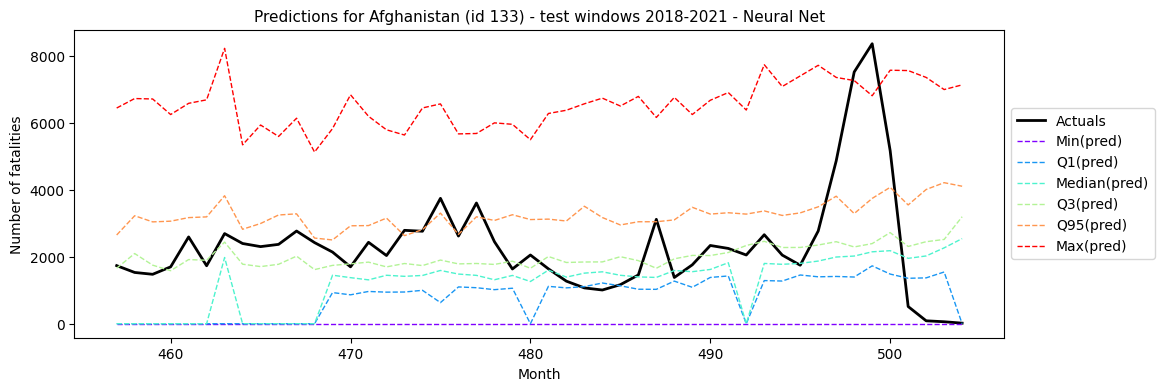

In [74]:
#------------------------------------
country_to_plot = 133 #133!!
method = 'NN'  # benchmark  NB  Hurdle  NN  NNNegBin
#------------------------------------
s_prediction_list = list(range(3, 15))

month_list_plot = []
actual_list = []
min_list = []
quant_025_list = []
quant_050_list = []
quant_075_list = []
quant_095_list = []
max_list = []

for year in actual_years:    
    dataset_index = actual_years.index(year)

    model_data = prediction_data_list[dataset_index][method]

    actual_data = actuals_df_list[dataset_index]['data']
    actual_group = actual_data.groupby('country_id')

    for s in s_prediction_list:
        
        prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
        empirical_distribution = model_data.loc[(prediction_month,country_to_plot),:].values.flatten()

        month_list_plot.append(prediction_month)
        actual_list.append(actual_group.get_group(country_to_plot).iloc[s-3,0])
        min_list.append(min(empirical_distribution))
        quant_025_list.append(np.percentile(empirical_distribution, 25))
        quant_050_list.append(np.percentile(empirical_distribution, 50))
        quant_075_list.append(np.percentile(empirical_distribution, 75))
        quant_095_list.append(np.percentile(empirical_distribution, 95))
        max_list.append(max(empirical_distribution))


import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

# Beispielwerte für Actuals und Quantile
months = month_list_plot
actuals = actual_list
minimum = min_list
quantile_25 = quant_025_list
quantile_50 = quant_050_list
quantile_75 = quant_075_list
quantile_95 = quant_095_list
maximum = max_list

plt.figure(figsize=(12, 4))

# Erzeuge das Liniendiagramm
plt.plot(months, actuals, color='black', linewidth=2, label='Actuals')
plt.plot(months, minimum, color=plt.cm.rainbow(0),linewidth=1, linestyle='--', label='Min(pred)')
plt.plot(months, quantile_25, color=plt.cm.rainbow(0.2),linewidth=1, linestyle='--', label='Q1(pred)')
plt.plot(months, quantile_50, color=plt.cm.rainbow(0.4),linewidth=1, linestyle='--', label='Median(pred)')
plt.plot(months, quantile_75, color=plt.cm.rainbow(0.6),linewidth=1, linestyle='--', label='Q3(pred)')
plt.plot(months, quantile_95, color=plt.cm.rainbow(0.8),linewidth=1, linestyle='--', label='Q95(pred)')
plt.plot(months, maximum, color=plt.cm.rainbow(1.0),linewidth=1, linestyle='--', label='Max(pred)')

plt.xlabel('Month')
plt.ylabel('Number of fatalities')
plt.title('Predictions for Afghanistan (id 133) - test windows 2018-2021 - Neural Net', fontsize=11, y=1) # Benchmark  NB   Hurdle   Neural Net
# Fasse die Quantile zu einem Eintrag in der Legende zusammen und platziere sie rechts
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Zeige das Diagramm
plt.show()

# CRPS over all countries

In [32]:
import CRPS.CRPS as pscore

s_prediction_list = list(range(3, 15))

month_list_plot = []
crps_last_poisson = []
crps_nb_baseline = []
crps_hurdle_baseline = []
crps_nn = []
crps_nn_negbin = []

for year in actual_years:    
    dataset_index = actual_years.index(year)

    last_poisson_data = prediction_data_list[dataset_index]['benchmark']
    nb_baseline_data = prediction_data_list[dataset_index]['NB']
    hurdle_baseline_data = prediction_data_list[dataset_index]['Hurdle']
    nn_data = prediction_data_list[dataset_index]['NN']
    nn_negbin_data = prediction_data_list[dataset_index]['NNNegBin']

    actual_data = actuals_df_list[dataset_index]['data']
    actual_group = actual_data.groupby('country_id')

    for s in s_prediction_list:
        
        mean_crps_last_poisson = []
        mean_crps_nb_baseline = []
        mean_crps_hurdle_baseline = []
        mean_crps_nn_empirical = []
        mean_crps_nn_negbin = []

        for country in country_list:

            prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
            y_true = actual_group.get_group(country).iloc[s-3,0]
            
            last_poisson_empirical_distribution = last_poisson_data.loc[(prediction_month,country),:].values.flatten()
            nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
            hurdle_baseline_empirical_distribution = hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()
            nn_empirical_distribution = nn_data.loc[(prediction_month,country),:].values.flatten()
            nn_negbin_empirical_distribution = nn_negbin_data.loc[(prediction_month,country),:].values.flatten()

            mean_crps_last_poisson.append(pscore(last_poisson_empirical_distribution,y_true).compute()[0])
            mean_crps_nb_baseline.append(pscore(nb_baseline_empirical_distribution,y_true).compute()[0])
            mean_crps_hurdle_baseline.append(pscore(hurdle_baseline_empirical_distribution,y_true).compute()[0])
            mean_crps_nn_empirical.append(pscore(nn_empirical_distribution,y_true).compute()[0])
            mean_crps_nn_negbin.append(pscore(nn_negbin_empirical_distribution,y_true).compute()[0])

        month_list_plot.append(prediction_month)
        crps_last_poisson.append(np.mean(mean_crps_last_poisson))
        crps_nb_baseline.append(np.mean(mean_crps_nb_baseline))
        crps_hurdle_baseline.append(np.mean(mean_crps_hurdle_baseline))
        crps_nn.append(np.mean(mean_crps_nn_empirical))
        crps_nn_negbin.append(np.mean(mean_crps_nn_negbin))

C:\Users\Tobias\AppData\Local\Temp\ipykernel_20432\2509366716.py:38: PerformanceWarning: indexing past lexsort depth may impact performance.
  nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_20432\2509366716.py:39: PerformanceWarning: indexing past lexsort depth may impact performance.
  hurdle_baseline_empirical_distribution = hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_20432\2509366716.py:40: PerformanceWarning: indexing past lexsort depth may impact performance.
  nn_empirical_distribution = nn_data.loc[(prediction_month,country),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_20432\2509366716.py:41: PerformanceWarning: indexing past lexsort depth may impact performance.
  nn_negbin_empirical_distribution = nn_negbin_data.loc[(prediction_month,country),:].values.flatten()


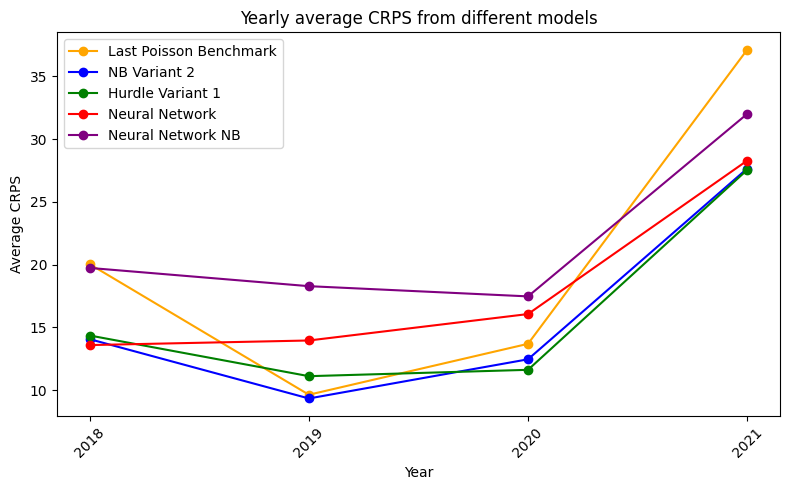

In [33]:
crps_by_year = {
    '2018': [],
    '2019': [],
    '2020': [],
    '2021': []
}

Keys_crps_by_year = list(crps_by_year.keys())
index_list = [[0,12], [12,24], [24,36], [36,48]]

for i in range(len(crps_by_year)):
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_last_poisson[index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_nb_baseline[index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_hurdle_baseline[index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_nn[index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_nn_negbin[index_list[i][0]:index_list[i][1]]))

import matplotlib.pyplot as plt

# Daten
methoden = [
    'Last Poisson Benchmark',
    'NB Variant 2',
    'Hurdle Variant 1',
    'Neural Network',
    'Neural Network NB'
]

# Plot erstellen
plt.figure(figsize=(8, 5))

colors = ['orange','blue','green','red','purple']

# Für jede Methode eine Linie zeichnen
for i, methode in enumerate(methoden):
    plt.plot(crps_by_year.keys(), [crps_by_year[jahr][i] for jahr in crps_by_year.keys()], marker='o', label=methode, color=colors[i])

# Titel und Achsenbeschriftungen
plt.title('Yearly average CRPS from different models')
plt.xlabel('Year')
plt.ylabel('Average CRPS')

# Legende hinzufügen
plt.legend() #loc='center left', bbox_to_anchor=(1, 0.5)

# Diagramm anzeigen
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [34]:
crps_by_year['2020']

[13.698199829842935,
 12.464821378196795,
 11.6259089708285,
 16.06991877181501,
 17.477550771461612]

In [35]:
np.mean([crps_by_year['2018'][-1], crps_by_year['2019'][-1], crps_by_year['2020'][-1], crps_by_year['2021'][-1]])

21.882187217597014

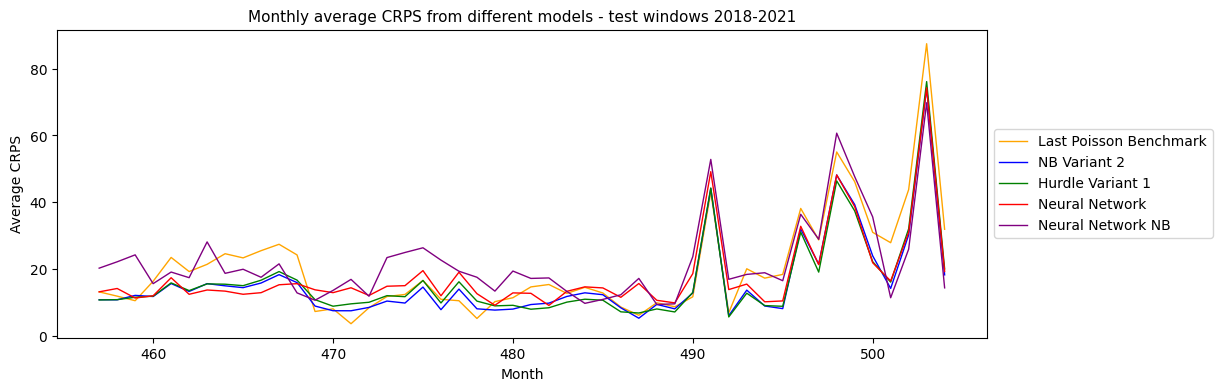

In [38]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np


months = month_list_plot
last_poisson = crps_last_poisson
nb_baseline = crps_nb_baseline
hurdle_baseline = crps_hurdle_baseline
nn = crps_nn
nn_negbin = crps_nn_negbin

plt.figure(figsize=(12, 4))

# Erzeuge das Liniendiagramm
plt.plot(months, last_poisson, color='orange', linewidth=1, label='Last Poisson Benchmark')
plt.plot(months, nb_baseline, color='blue', linewidth=1, label='NB Variant 2')
plt.plot(months, hurdle_baseline, color='green', linewidth=1, label='Hurdle Variant 1')
plt.plot(months, nn, linewidth=1, color='red', label='Neural Network')
plt.plot(months, nn_negbin, linewidth=1, color='purple', label='Neural Network NB')

plt.title('Monthly average CRPS from different models - test windows 2018-2021', fontsize=11, y=1)
plt.xlabel('Month')
plt.ylabel('Average CRPS')

# Fasse die Quantile zu einem Eintrag in der Legende zusammen und platziere sie rechts
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Zeige das Diagramm
plt.show()

# CRPS over different levels of conflicts

In [39]:
import CRPS.CRPS as pscore

s_prediction_list = list(range(3, 15))

month_list_plot = []

crps_last_poisson_low = []
crps_nb_baseline_low = []
crps_hurdle_baseline_low = []
crps_nn_low = []
crps_nn_negbin_low = []

crps_last_poisson_middle = []
crps_nb_baseline_middle = []
crps_hurdle_baseline_middle = []
crps_nn_middle = []
crps_nn_negbin_middle = []

crps_last_poisson_high = []
crps_nb_baseline_high = []
crps_hurdle_baseline_high = []
crps_nn_high = []
crps_nn_negbin_high = []

for year in actual_years:    
    dataset_index = actual_years.index(year)

    last_poisson_data = prediction_data_list[dataset_index]['benchmark']
    nb_baseline_data = prediction_data_list[dataset_index]['NB']
    hurdle_baseline_data = prediction_data_list[dataset_index]['Hurdle']
    nn_data = prediction_data_list[dataset_index]['NN']
    nn_negbin_data = prediction_data_list[dataset_index]['NNNegBin']

    actual_data = actuals_df_list[dataset_index]['data']
    actual_group = actual_data.groupby('country_id')

    for s in s_prediction_list:
        
        mean_crps_last_poisson_low = []
        mean_crps_nb_baseline_low = []
        mean_crps_hurdle_baseline_low = []
        mean_crps_nn_empirical_low = []
        mean_crps_nn_negbin_low = []

        mean_crps_last_poisson_middle = []
        mean_crps_nb_baseline_middle = []
        mean_crps_hurdle_baseline_middle = []
        mean_crps_nn_empirical_middle = []
        mean_crps_nn_negbin_middle = []

        mean_crps_last_poisson_high = []
        mean_crps_nb_baseline_high = []
        mean_crps_hurdle_baseline_high = []
        mean_crps_nn_empirical_high = []
        mean_crps_nn_negbin_high = []

        for country in country_list:

            prediction_month = actual_data.index.get_level_values('month_id').unique().to_list()[s-3]
            y_true = actual_group.get_group(country).iloc[s-3,0]
            
            last_poisson_empirical_distribution = last_poisson_data.loc[(prediction_month,country),:].values.flatten()
            nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
            hurdle_baseline_empirical_distribution = hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()
            nn_empirical_distribution = nn_data.loc[(prediction_month,country),:].values.flatten()
            nn_negbin_empirical_distribution = nn_negbin_data.loc[(prediction_month,country),:].values.flatten()


            if country in countries_with_low_conflict_list:
                mean_crps_last_poisson_low.append(pscore(last_poisson_empirical_distribution,y_true).compute()[0])
                mean_crps_nb_baseline_low.append(pscore(nb_baseline_empirical_distribution,y_true).compute()[0])
                mean_crps_hurdle_baseline_low.append(pscore(hurdle_baseline_empirical_distribution,y_true).compute()[0])
                mean_crps_nn_empirical_low.append(pscore(nn_empirical_distribution,y_true).compute()[0])
                mean_crps_nn_negbin_low.append(pscore(nn_negbin_empirical_distribution,y_true).compute()[0])

            elif country in countries_with_middle_conflict_list:
                mean_crps_last_poisson_middle.append(pscore(last_poisson_empirical_distribution,y_true).compute()[0])
                mean_crps_nb_baseline_middle.append(pscore(nb_baseline_empirical_distribution,y_true).compute()[0])
                mean_crps_hurdle_baseline_middle.append(pscore(hurdle_baseline_empirical_distribution,y_true).compute()[0])
                mean_crps_nn_empirical_middle.append(pscore(nn_empirical_distribution,y_true).compute()[0])
                mean_crps_nn_negbin_middle.append(pscore(nn_negbin_empirical_distribution,y_true).compute()[0])

            elif country in countries_with_high_conflict_list:
                mean_crps_last_poisson_high.append(pscore(last_poisson_empirical_distribution,y_true).compute()[0])
                mean_crps_nb_baseline_high.append(pscore(nb_baseline_empirical_distribution,y_true).compute()[0])
                mean_crps_hurdle_baseline_high.append(pscore(hurdle_baseline_empirical_distribution,y_true).compute()[0])
                mean_crps_nn_empirical_high.append(pscore(nn_empirical_distribution,y_true).compute()[0])
                mean_crps_nn_negbin_high.append(pscore(nn_negbin_empirical_distribution,y_true).compute()[0])

        month_list_plot.append(prediction_month)

        crps_last_poisson_low.append(np.mean(mean_crps_last_poisson_low))
        crps_nb_baseline_low.append(np.mean(mean_crps_nb_baseline_low))
        crps_hurdle_baseline_low.append(np.mean(mean_crps_hurdle_baseline_low))
        crps_nn_low.append(np.mean(mean_crps_nn_empirical_low))
        crps_nn_negbin_low.append(np.mean(mean_crps_nn_negbin_low))

        crps_last_poisson_middle.append(np.mean(mean_crps_last_poisson_middle))
        crps_nb_baseline_middle.append(np.mean(mean_crps_nb_baseline_middle))
        crps_hurdle_baseline_middle.append(np.mean(mean_crps_hurdle_baseline_middle))
        crps_nn_middle.append(np.mean(mean_crps_nn_empirical_middle))
        crps_nn_negbin_middle.append(np.mean(mean_crps_nn_negbin_middle))

        crps_last_poisson_high.append(np.mean(mean_crps_last_poisson_high))
        crps_nb_baseline_high.append(np.mean(mean_crps_nb_baseline_high))
        crps_hurdle_baseline_high.append(np.mean(mean_crps_hurdle_baseline_high))
        crps_nn_high.append(np.mean(mean_crps_nn_empirical_high))
        crps_nn_negbin_high.append(np.mean(mean_crps_nn_negbin_high))

C:\Users\Tobias\AppData\Local\Temp\ipykernel_20432\1646102157.py:63: PerformanceWarning: indexing past lexsort depth may impact performance.
  nb_baseline_empirical_distribution = nb_baseline_data.loc[(prediction_month,country),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_20432\1646102157.py:64: PerformanceWarning: indexing past lexsort depth may impact performance.
  hurdle_baseline_empirical_distribution = hurdle_baseline_data.loc[(prediction_month,country),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_20432\1646102157.py:65: PerformanceWarning: indexing past lexsort depth may impact performance.
  nn_empirical_distribution = nn_data.loc[(prediction_month,country),:].values.flatten()
C:\Users\Tobias\AppData\Local\Temp\ipykernel_20432\1646102157.py:66: PerformanceWarning: indexing past lexsort depth may impact performance.
  nn_negbin_empirical_distribution = nn_negbin_data.loc[(prediction_month,country),:].values.flatten()


In [40]:
crps_conflict_level = {'low':{'pois':crps_last_poisson_low, 
                              'NB':crps_nb_baseline_low, 
                              'Hurdle':crps_hurdle_baseline_low, 
                              'NN':crps_nn_low, 
                              'NN_NegBin':crps_nn_negbin_low},
                        'middle':{'pois':crps_last_poisson_middle, 
                              'NB':crps_nb_baseline_middle, 
                              'Hurdle':crps_hurdle_baseline_middle, 
                              'NN':crps_nn_middle, 
                              'NN_NegBin':crps_nn_negbin_middle},
                        'high':{'pois':crps_last_poisson_high, 
                              'NB':crps_nb_baseline_high, 
                              'Hurdle':crps_hurdle_baseline_high, 
                              'NN':crps_nn_high, 
                              'NN_NegBin':crps_nn_negbin_high},
                              }

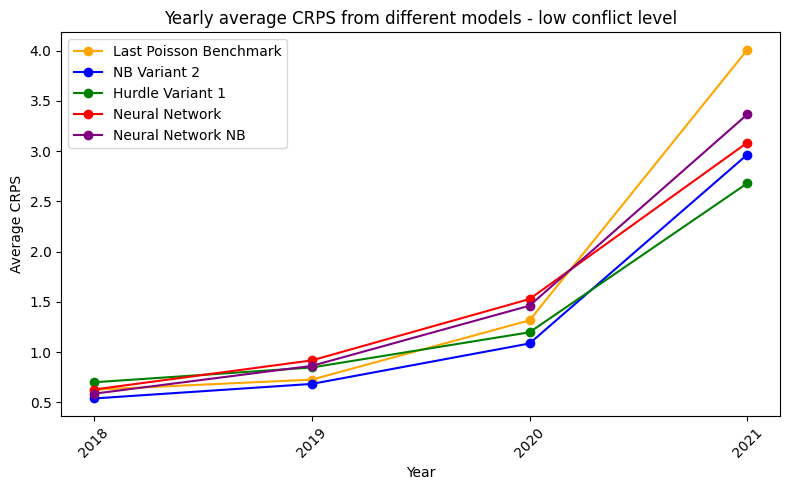

In [45]:
conflict_level = 'low'

crps_by_year = {
    '2018': [],
    '2019': [],
    '2020': [],
    '2021': []
}

Keys_crps_by_year = list(crps_by_year.keys())
index_list = [[0,12], [12,24], [24,36], [36,48]]

for i in range(len(crps_by_year)):
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_conflict_level[conflict_level]['pois'][index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_conflict_level[conflict_level]['NB'][index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_conflict_level[conflict_level]['Hurdle'][index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_conflict_level[conflict_level]['NN'][index_list[i][0]:index_list[i][1]]))
    crps_by_year[Keys_crps_by_year[i]].append(np.mean(crps_conflict_level[conflict_level]['NN_NegBin'][index_list[i][0]:index_list[i][1]]))

import matplotlib.pyplot as plt

# Daten
methoden = [
    'Last Poisson Benchmark',
    'NB Variant 2',
    'Hurdle Variant 1',
    'Neural Network',
    'Neural Network NB'
]

# Plot erstellen
plt.figure(figsize=(8, 5))

colors = ['orange','blue','green','red','purple']

# Für jede Methode eine Linie zeichnen
for i, methode in enumerate(methoden):
    plt.plot(crps_by_year.keys(), [crps_by_year[jahr][i] for jahr in crps_by_year.keys()], marker='o', label=methode, color=colors[i])

# Titel und Achsenbeschriftungen
plt.title('Yearly average CRPS from different models - '  + str(conflict_level) + ' conflict level')
plt.xlabel('Year')
plt.ylabel('Average CRPS')

# Legende hinzufügen
plt.legend() #loc='center left', bbox_to_anchor=(1, 0.5)

# Diagramm anzeigen
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

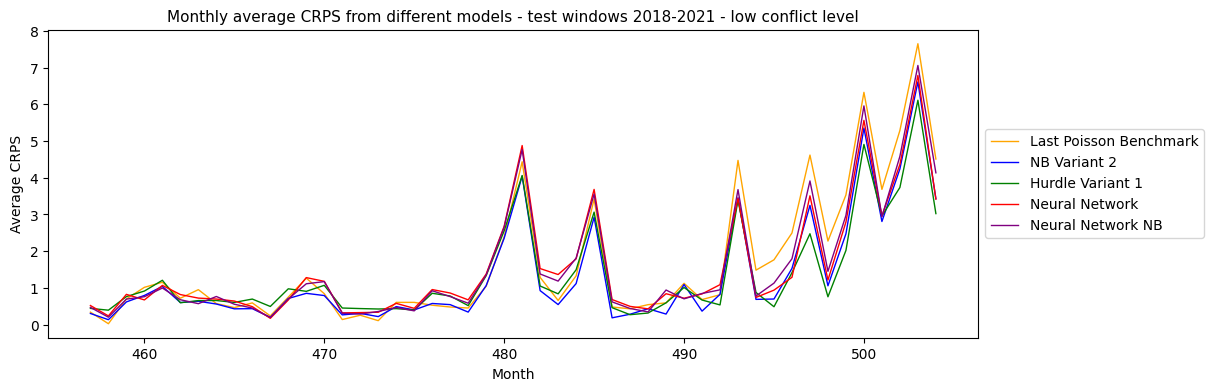

In [47]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

conflict_level = 'low'

months = month_list_plot

last_poisson = crps_conflict_level[conflict_level]['pois']
nb_baseline = crps_conflict_level[conflict_level]['NB']
hurdle_baseline = crps_conflict_level[conflict_level]['Hurdle']
nn = crps_conflict_level[conflict_level]['NN']
nn_negbin = crps_conflict_level[conflict_level]['NN_NegBin']

plt.figure(figsize=(12, 4))

# Erzeuge das Liniendiagramm
plt.plot(months, last_poisson, color='orange', linewidth=1, label='Last Poisson Benchmark')
plt.plot(months, nb_baseline, color='blue', linewidth=1, label='NB Variant 2')
plt.plot(months, hurdle_baseline, color='green', linewidth=1, label='Hurdle Variant 1')
plt.plot(months, nn, linewidth=1, color='red', label='Neural Network')
plt.plot(months, nn_negbin, linewidth=1, color='purple', label='Neural Network NB')

plt.title('Monthly average CRPS from different models - test windows 2018-2021 - ' + str(conflict_level) + ' conflict level', fontsize=11, y=1)
plt.xlabel('Month')
plt.ylabel('Average CRPS')

# Fasse die Quantile zu einem Eintrag in der Legende zusammen und platziere sie rechts
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Zeige das Diagramm
plt.show()